### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [2]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [4]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-06 00:58:34--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 262521 (256K) [text/plain]
Сохранение в: ‘onegin.txt.2’

onegin.txt.2        100%[===================>] 256,37K  1,08MB/s    за 0,2s    

2024-11-06 00:58:35 (1,08 MB/s) - ‘onegin.txt.2’ сохранён [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [5]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [6]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [9]:
data = next(generate_chunk())
print(data)

[[83 62 57 ...  1 60 61]
 [83 53  1 ... 55 45  1]
 [83 58 45 ...  7  1 26]
 ...
 [83  0 63 ... 54  5  0]
 [83 58 50 ... 60 59 55]
 [83 59 54 ... 62 60 59]]


Далее вам предстоит написать код для обучения модели и генерации текста.

In [18]:
from torch.autograd import Variable

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [19]:
def train_rnn(x, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    for p in range(seq_length):
        output, hidden = decoder(x[p], hidden)
        loss += criterion(output, target[p].view(1))

    loss.backward()
    optimizer.step()
    
    return loss.item() / seq_length

In [20]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [24]:
batch_size = 256
seq_length = 100 
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']
n_epochs = 500

hidden_dim = 100
lr = 0.005

decoder = RNNModel(num_tokens , hidden_dim, num_tokens)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []
loss_avg = 0
start = time.time()

for epoch in range(n_epochs):
    chunks = next(generate_chunk())
    for chunk in chunks:
        chunk = torch.tensor(chunk, dtype=torch.long).to(device)
        loss = train_rnn(chunk[:-1], chunk[1:])
        loss_avg += loss
    loss_avg /= batch_size
    all_losses.append(loss_avg)
    if epoch % 10 == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss_avg ))


 7s (0 0%) 2.7093]
 22s (10 2%) 2.3452]
 44s (20 4%) 2.2198]
 58s (30 6%) 2.1532]
 16s (40 8%) 2.2395]
 26s (50 10%) 2.1408]
 38s (60 12%) 2.1972]
 49s (70 14%) 2.1977]
 59s (80 16%) 2.1582]
 10s (90 18%) 2.2369]
 20s (100 20%) 2.2290]
 31s (110 22%) 2.1985]
 42s (120 24%) 2.2061]
 53s (130 26%) 2.2590]
 4s (140 28%) 2.2328]
 15s (150 30%) 2.2659]
 26s (160 32%) 2.1701]
 36s (170 34%) 2.2338]
 47s (180 36%) 2.2900]
 57s (190 38%) 2.2341]
 8s (200 40%) 2.2343]
 18s (210 42%) 2.3089]
 29s (220 44%) 2.2708]
 39s (230 46%) 2.2382]
 51s (240 48%) 2.2868]
 2s (250 50%) 2.2680]
 13s (260 52%) 2.2457]
 23s (270 54%) 2.2670]
 34s (280 56%) 2.2595]
 44s (290 57%) 2.2694]
 55s (300 60%) 2.2918]
 5s (310 62%) 2.2810]
 15s (320 64%) 2.2530]
 26s (330 66%) 2.2456]
 36s (340 68%) 2.2930]
 47s (350 70%) 2.2674]
 57s (360 72%) 2.2347]
 9s (370 74%) 2.2359]
 22s (380 76%) 2.3315]
 35s (390 78%) 2.2338]
 48s (400 80%) 2.2437]
 4s (410 82%) 2.2446]
 18s (420 84%) 2.2778]
 33s (430 86%) 2.2485]
 40s (440 8

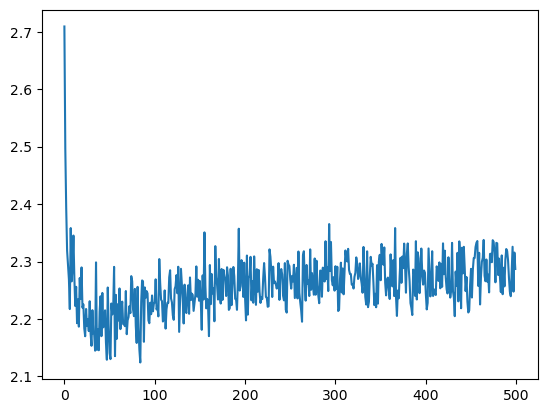

In [25]:
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.show()

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

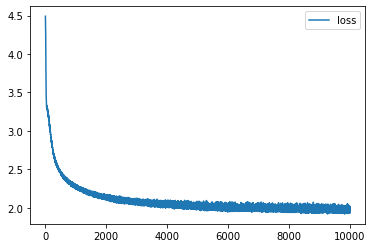

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [73]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    prime_input = []
    if seed_phrase is not None:
        prime_input = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        prime_input = [token_to_idx['<sos>']]

    hidden = decoder.init_hidden()
    prime_input = torch.tensor(prime_input, dtype=torch.long).to(device)
    predicted = seed_phrase

    # Use priming string to "build up" hidden state
    for p in range(len(seed_phrase) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(max_length - len(seed_phrase)):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = tokens[top_i]
        predicted += predicted_char
        inp = top_i

    return predicted

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [74]:
print(generate_sample(decoder, ' мой дядя самых честных правил', max_length=500, temperature=1.))

 мой дядя самых честных правили вомок;
всё епеповая шут верею,
и ковлеку колугать одитель соредышит поклугого онут вети одь когнявша;
студа. вод
усь рокекие него вно, шумней на увореглеще как и перу мир пода
он двет будашь зишидендкой осв лод кошком любь, вечил;
ипет;
коит сима, и в крого, и бы озорых их я, я блесний! костых, разушут,
покит, мог, озго мель,
всё славна не грахона не рифким я киминоей уз что возя к злык поо с кросненк, верного в вер
она обола.
онит: вредь квящах отиках
прудет род 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [67]:
seed_phrase = ' мой дядя самых честных правил'

In [75]:
generated_phrases = [
     generate_sample(
         decoder,
         seed_phrase,
         max_length=500,
         temperature=1.
     )
     for _ in range(10)
 ]


In [77]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!